In [22]:
# import libaries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import random
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from sklearn import metrics
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [23]:
# 데이터 load
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/MyDrive/dmp/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dmp/test.csv')
test=test.set_index('Timestamp')
train=train.set_index('Timestamp')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# train, test, valid split

for i in range(len(train.columns)):
  if train.columns[i][-7:] == 'Request':
       train[train.columns[i][:-7]+'ratio'] = train[train.columns[i+1]]/train[train.columns[i]]



for i in range(len(test.columns)):
  if test.columns[i][-7:] == 'Request':
       test[test.columns[i][:-7]+'ratio'] = test[test.columns[i+1]]/test[test.columns[i]]


In [25]:
train = train.fillna(0)
test = test.fillna(0)

In [26]:
info_data = train.loc[:,[i for i in train.columns.values.tolist() if 'INFO' in i]]
login_1_data = train.loc[:,[i for i in train.columns.values.tolist() if 'LOGIN-01' in i]]
login_2_data = train.loc[:,[i for i in train.columns.values.tolist() if 'LOGIN-02' in i]]
login_3_data = train.loc[:,[i for i in train.columns.values.tolist() if 'LOGIN-03' in i]]
login_4_data = train.loc[:,[i for i in train.columns.values.tolist() if 'LOGIN-04' in i]]
login_5_data = train.loc[:,[i for i in train.columns.values.tolist() if 'LOGIN-05' in i]]
menu_1_data = train.loc[:,[i for i in train.columns.values.tolist() if 'MENU-01' in i]]
menu_2_data = train.loc[:,[i for i in train.columns.values.tolist() if 'MENU-02' in i]]
menu_3_data = train.loc[:,[i for i in train.columns.values.tolist() if 'MENU-03' in i]]
menu_4_data = train.loc[:,[i for i in train.columns.values.tolist() if 'MENU-04' in i]]

info_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'INFO' in i]]
login_1_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'LOGIN-01' in i]]
login_2_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'LOGIN-02' in i]]
login_3_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'LOGIN-03' in i]]
login_4_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'LOGIN-04' in i]]
login_5_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'LOGIN-05' in i]]
menu_1_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'MENU-01' in i]]
menu_2_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'MENU-02' in i]]
menu_3_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'MENU-03' in i]]
menu_4_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'MENU-04' in i]]

session = train.iloc[:,30:]
session_test = test.iloc[:,30:]

In [27]:
# 데이터 차원 변경 -> input 데이터 형식 맞춤 (3차원)
def rs(x):
  x = np.array(x).reshape(x.shape[0],1,x.shape[1])
  return x


data_list = [info_data, login_1_data,login_2_data,login_3_data,login_4_data,login_5_data,menu_1_data,menu_2_data,menu_3_data,menu_4_data,session]
data_list_test = [info_data_test, login_1_data_test,login_2_data_test,login_3_data_test,login_4_data_test,login_5_data_test,menu_1_data_test,menu_2_data_test,menu_3_data_test,menu_4_data_test,session_test]

info_data_x = rs(info_data)
info_data_test_x = rs(info_data_test)

login_1_data_x = rs(login_1_data)
login_1_data_test_x = rs(login_1_data_test)

login_2_data_x = rs(login_2_data)
login_2_data_test_x = rs(login_2_data_test)

login_3_data_x = rs(login_3_data)
login_3_data_test_x = rs(login_3_data_test)

login_4_data_x = rs(login_4_data)
login_4_data_test_x = rs(login_4_data_test)

login_5_data_x = rs(login_5_data)
login_5_data_test_x = rs(login_5_data_test)

menu_1_data_x = rs(menu_1_data)
menu_1_data_test_x = rs(menu_1_data_test)

menu_2_data_x = rs(menu_2_data)
menu_2_data_test_x = rs(menu_2_data_test)

menu_3_data_x = rs(menu_3_data)
menu_3_data_test_x = rs(menu_3_data_test)

menu_4_data_x = rs(menu_4_data)
menu_4_data_test_x = rs(menu_4_data_test)

session_x = rs(session)
session_test_x = rs(session_test)

reshape_list_train = [info_data_x, login_1_data_x,login_2_data_x,login_3_data_x,login_4_data_x,login_5_data_x,menu_1_data_x,menu_2_data_x,menu_3_data_x,menu_4_data_x,session_x]
reshape_list_test = [info_data_test_x, login_1_data_test_x,login_2_data_test_x,login_3_data_test_x,login_4_data_test_x,login_5_data_test_x,menu_1_data_test_x,menu_2_data_test_x,menu_3_data_test_x,menu_4_data_test_x,session_test_x]

#train = np.array(train).reshape(train.shape[0],1,train.shape[1])
#test = np.array(test).reshape(test.shape[0],1,test.shape[1])

In [28]:
info_data_x.shape

(105120, 1, 4)

In [29]:
sum(np.isnan(login_1_data_x)==False)

array([[105120, 105120, 105120, 105120]])

In [30]:
login_1_data_x[np.isnan(login_1_data_x)==True]

array([], dtype=float64)

In [31]:
# 신경망 구축

# autoencoder 신경망 구축 (신경망을 LSTM layer로 구축)
def autoencoder_model(X):
  inputs = Input(shape=(X.shape[1], X.shape[2]))
  L1 = LSTM(140, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
  L2 = Dropout(rate = 0.2)(L1)
  L3 = LSTM(70, activation='relu', return_sequences=False)(L2)
  L4 = RepeatVector(X.shape[1])(L3)
  L5 = LSTM(70, activation='relu', return_sequences=True)(L4)
  L6 = LSTM(140, activation='relu', return_sequences=True)(L5)
  L7 = Dropout(rate = 0.2)(L6)
  output = TimeDistributed(Dense(X.shape[2]))(L7)
  model = Model(inputs=inputs, outputs=output)

  return model

In [32]:
def modeling(train_x):

  model = autoencoder_model(train_x)
  model.compile(optimizer='adam', loss='mae')
  model.summary()

  nb_epochs = 30
  batch_size = 32
  history = model.fit(train_x, train_x, epochs=nb_epochs, batch_size=batch_size)
  return model,history

In [33]:
# 학습 결과 시각화
def viz(hist):
  fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
  ax.plot(hist.history['loss'], 'b', label='Train', linewidth=2)
  ax.set_title('Model loss', fontsize=16)
  ax.set_ylabel('Loss (mae)')
  ax.set_xlabel('Epoch')
  ax.legend(loc='upper right')
  plt.show()

In [34]:
# loss
def loss_fun(model,history,train_x,x):

  x_pred_3d = model.predict(train_x)
  x_pred = x_pred_3d.reshape(x_pred_3d.shape[0], x_pred_3d.shape[2])
  x_pred = pd.DataFrame(x_pred,columns = x.columns)
  x_pred.index = x.index

  scored = pd.DataFrame(index = x.index)
  xtrain = train_x.reshape(train_x.shape[0], train_x.shape[2])
  scored['Loss_mae'] =np.mean(np.abs(x_pred-xtrain),axis=1)
  sns.distplot(scored['Loss_mae'],kde=True)

  return model, scored

In [35]:
# test
def testing(model, score, test_x, t,feature):

  threshold = np.percentile(score,100)
  test_predictions_3d = model.predict(test_x)
  test_predictions = test_predictions_3d.reshape(test_predictions_3d.shape[0], test_predictions_3d.shape[2])
  test_predictions = pd.DataFrame(test_predictions,columns = t.columns)
  test_predictions.index = t.index

  scored2 = pd.DataFrame(index = t.index)
  x_test_ = test_x.reshape(test_x.shape[0], test_x.shape[2])
  scored2[feature+'mae'] = np.mean(np.abs(test_predictions - x_test_), axis=1)

  scored2[feature+'threshold'] = threshold
  scored2[feature+'Anomaly'] = scored2[feature+'mae'] > scored2[feature+'threshold']
    
  

  return scored2

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 140)            81200     
                                                                 
 dropout_2 (Dropout)         (None, 1, 140)            0         
                                                                 
 lstm_5 (LSTM)               (None, 70)                59080     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 1, 70)             39480     
                                                           

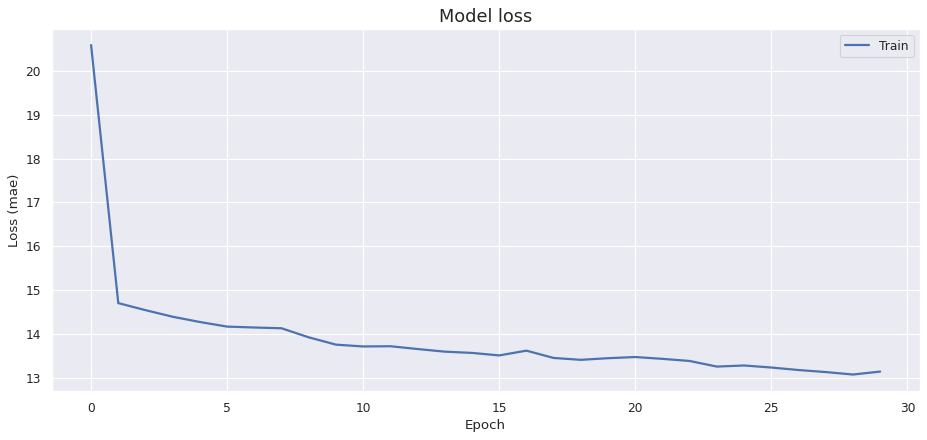

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 140)            81200     
                                                                 
 dropout_4 (Dropout)         (None, 1, 140)            0         
                                                                 
 lstm_9 (LSTM)               (None, 70)                59080     
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 1, 70)             39480     
                                                           

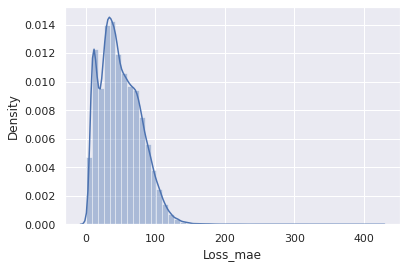

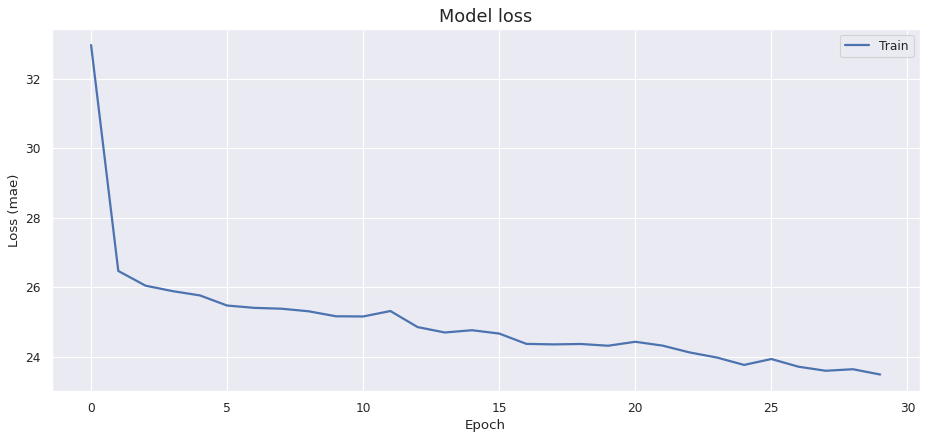

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 140)            81200     
                                                                 
 dropout_6 (Dropout)         (None, 1, 140)            0         
                                                                 
 lstm_13 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 1, 70)             39480     
                                                           

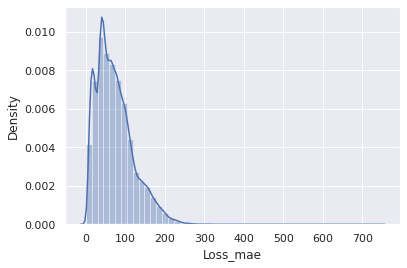

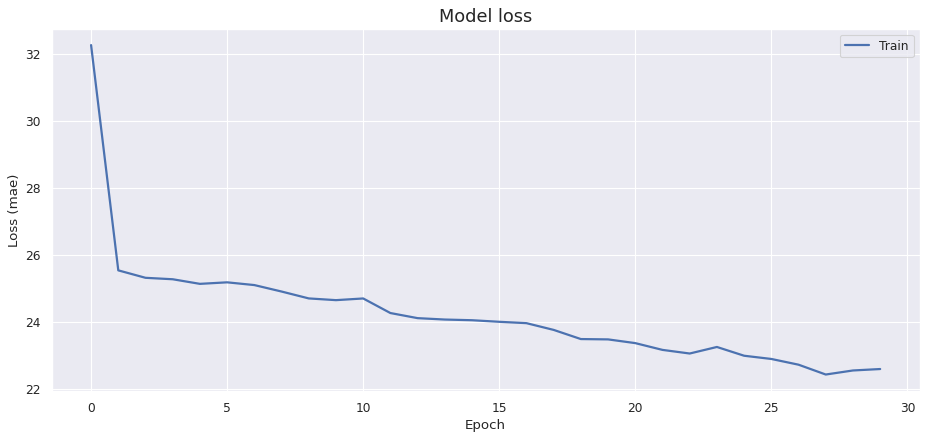

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 140)            81200     
                                                                 
 dropout_8 (Dropout)         (None, 1, 140)            0         
                                                                 
 lstm_17 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 1, 70)             39480     
                                                           

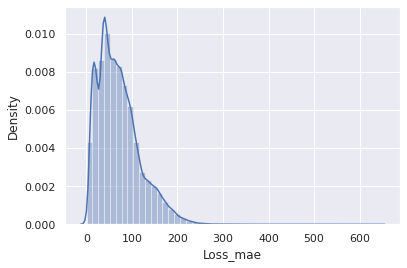

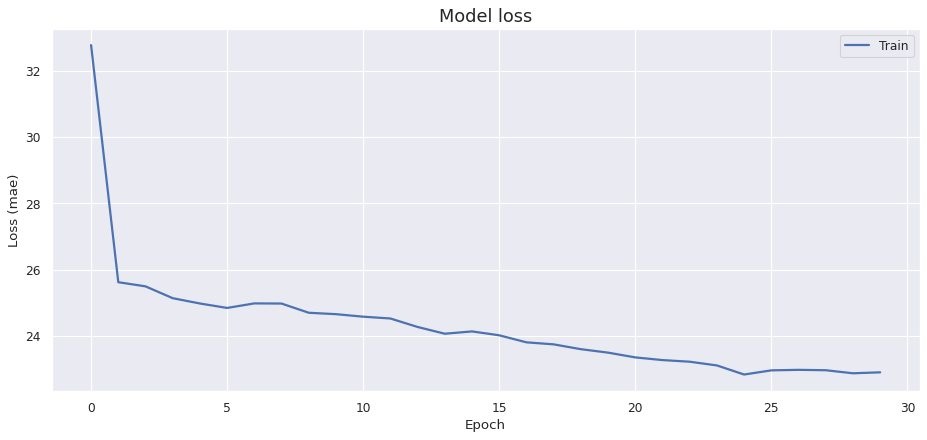

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 1, 140)            81200     
                                                                 
 dropout_10 (Dropout)        (None, 1, 140)            0         
                                                                 
 lstm_21 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_5 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_22 (LSTM)              (None, 1, 70)             39480     
                                                           

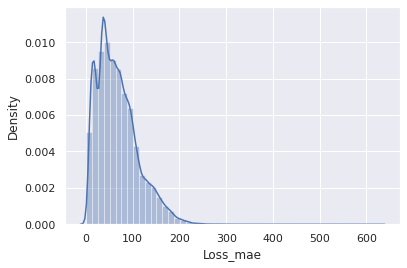

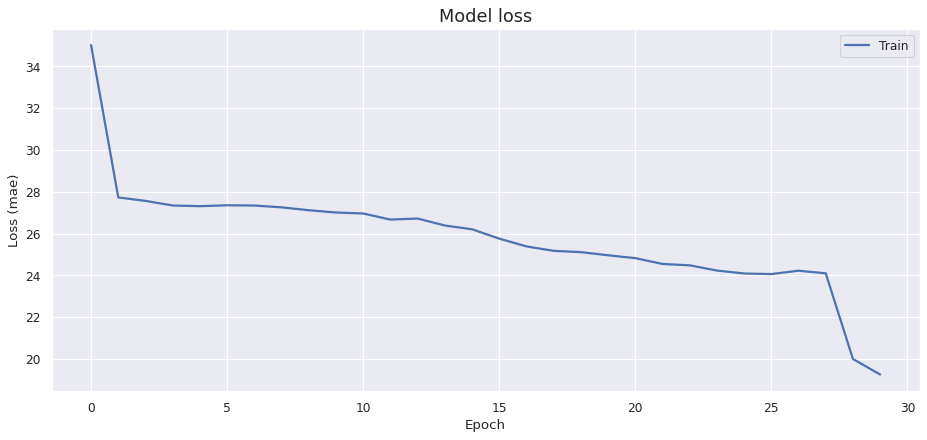

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_24 (LSTM)              (None, 1, 140)            81200     
                                                                 
 dropout_12 (Dropout)        (None, 1, 140)            0         
                                                                 
 lstm_25 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_6 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_26 (LSTM)              (None, 1, 70)             39480     
                                                           

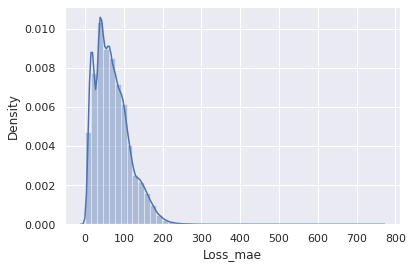

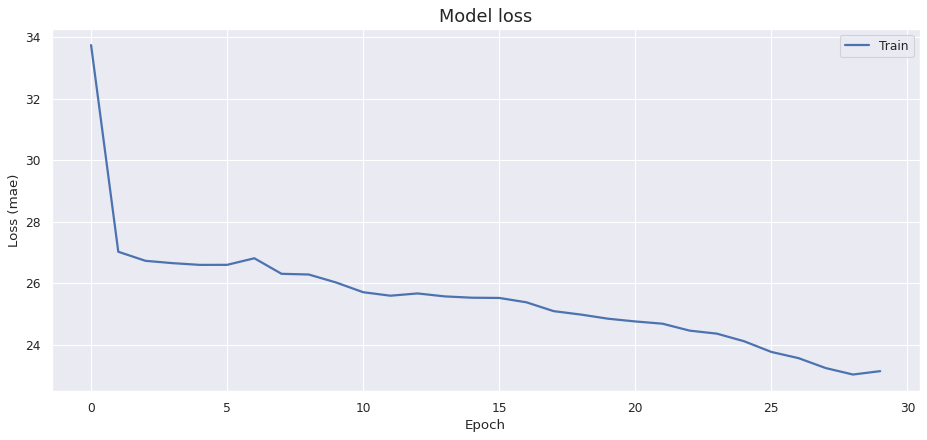

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_28 (LSTM)              (None, 1, 140)            81200     
                                                                 
 dropout_14 (Dropout)        (None, 1, 140)            0         
                                                                 
 lstm_29 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_7 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_30 (LSTM)              (None, 1, 70)             39480     
                                                           

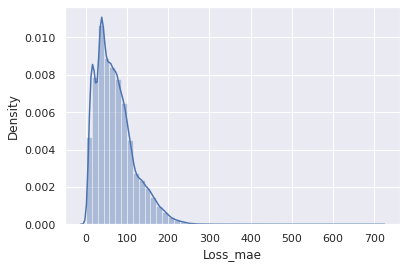

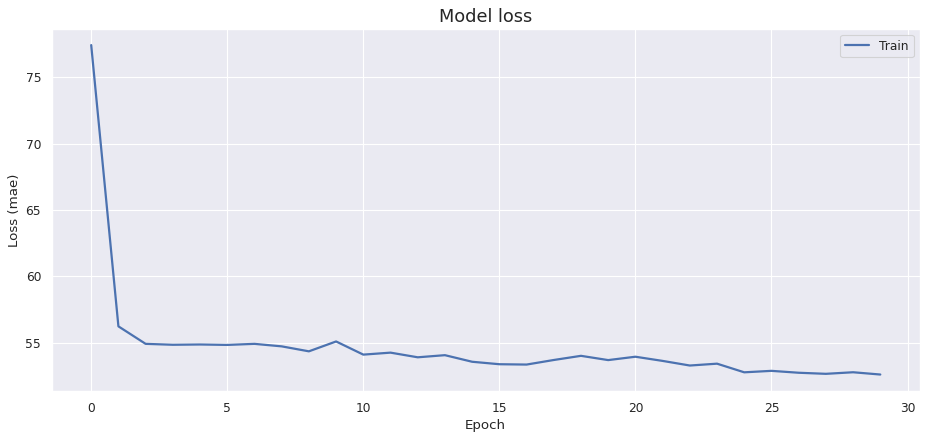

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_32 (LSTM)              (None, 1, 140)            81200     
                                                                 
 dropout_16 (Dropout)        (None, 1, 140)            0         
                                                                 
 lstm_33 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_8 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_34 (LSTM)              (None, 1, 70)             39480     
                                                           

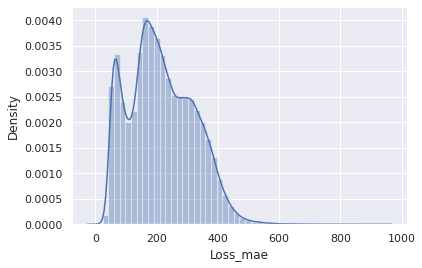

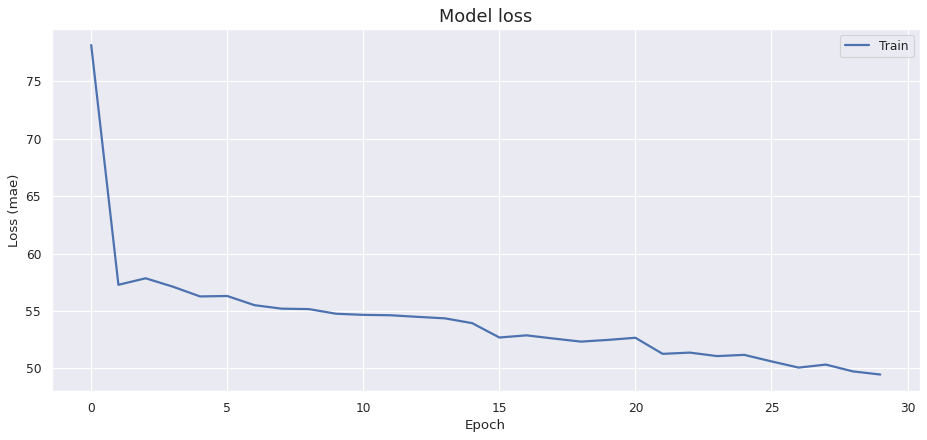

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1, 4)]            0         
                                                                 
 lstm_36 (LSTM)              (None, 1, 140)            81200     
                                                                 
 dropout_18 (Dropout)        (None, 1, 140)            0         
                                                                 
 lstm_37 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_9 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_38 (LSTM)              (None, 1, 70)             39480     
                                                           

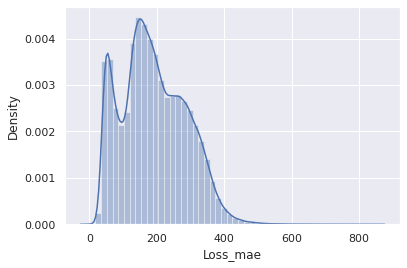

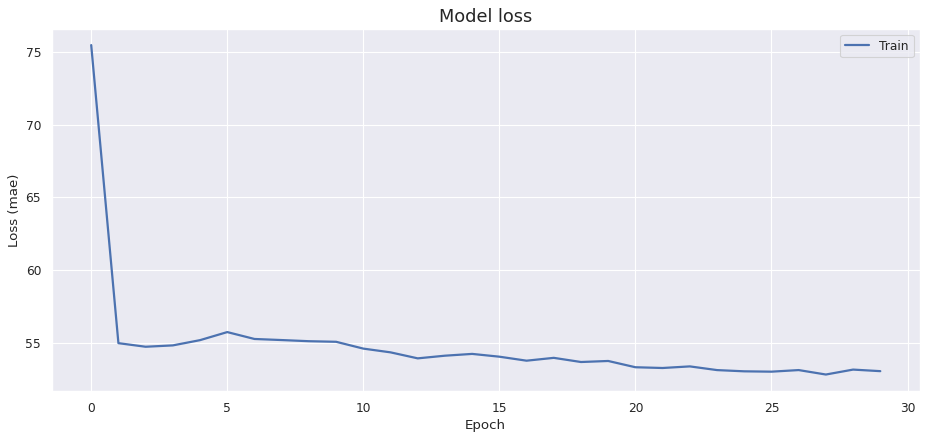

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1, 4)]            0         
                                                                 
 lstm_40 (LSTM)              (None, 1, 140)            81200     
                                                                 
 dropout_20 (Dropout)        (None, 1, 140)            0         
                                                                 
 lstm_41 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_10 (RepeatVec  (None, 1, 70)            0         
 tor)                                                            
                                                                 
 lstm_42 (LSTM)              (None, 1, 70)             39480     
                                                          

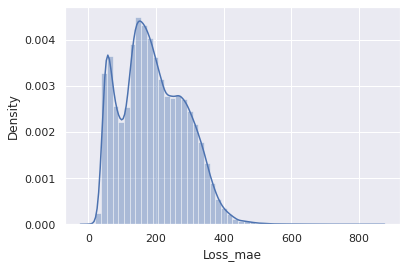

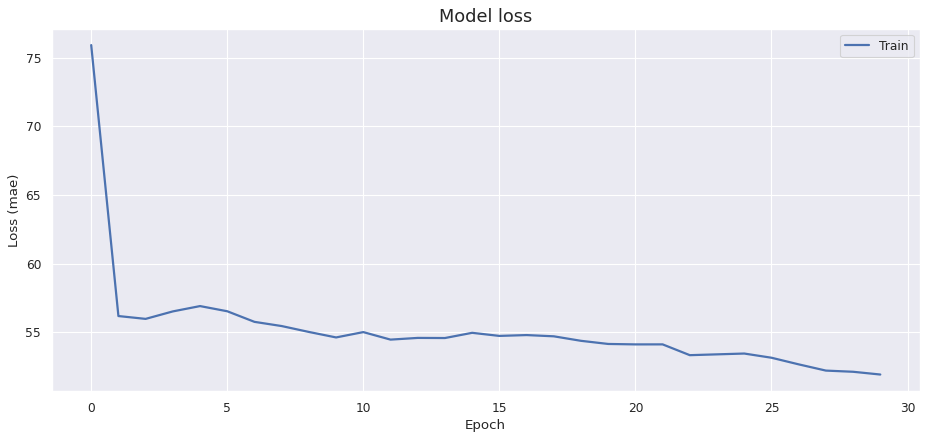

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1, 13)]           0         
                                                                 
 lstm_44 (LSTM)              (None, 1, 140)            86240     
                                                                 
 dropout_22 (Dropout)        (None, 1, 140)            0         
                                                                 
 lstm_45 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_11 (RepeatVec  (None, 1, 70)            0         
 tor)                                                            
                                                                 
 lstm_46 (LSTM)              (None, 1, 70)             39480     
                                                          

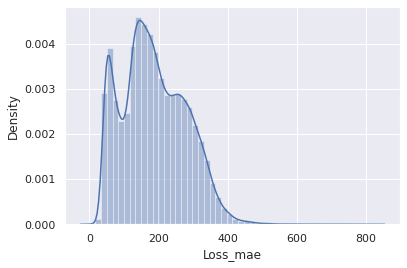

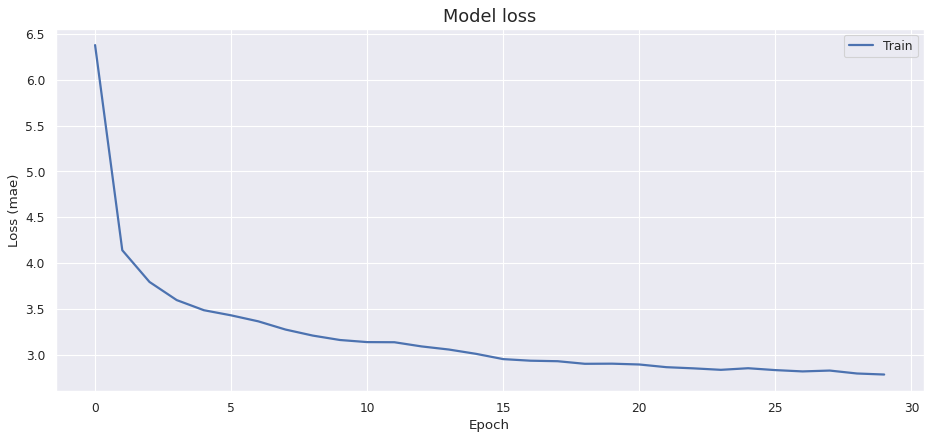

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


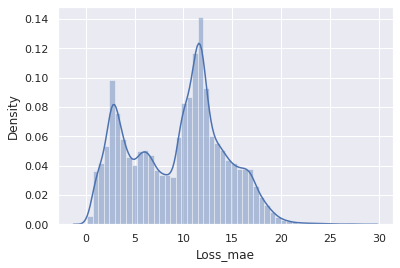

In [36]:
feature_list = ['info', 'login_1','login_2','login_3','login_4','login_5','menu_1','menu_2','menu_3','menu_4','session']
total_result = pd.DataFrame(index=test.index)


for i in range(len(feature_list)):

  m, h = modeling(reshape_list_train[i]) #reshape_list_train[i] -> reshape data, m = model, h = history
  viz(h) # viz history
  m,s = loss_fun(m,h,reshape_list_train[i],data_list[i]) # lossfunction ->model,history,train_x, index용 데이터 -> model, scored
  result = testing(m,s,reshape_list_test[i],data_list_test[i],feature_list[i]) #testing -> test_x: reshape_data  , t-> index용 데이터 feature -> 결과 column용 데이터
  total_result = pd.concat([total_result, result],axis=1)

In [37]:
total_result.to_csv('/content/drive/MyDrive/dmp/result_not_scaling.csv',index = True)

In [38]:
total_result.value_counts()

infomae     infothreshold  infoAnomaly  login_1mae  login_1threshold  login_1Anomaly  login_2mae  login_2threshold  login_2Anomaly  login_3mae  login_3threshold  login_3Anomaly  login_4mae  login_4threshold  login_4Anomaly  login_5mae  login_5threshold  login_5Anomaly  menu_1mae   menu_1threshold  menu_1Anomaly  menu_2mae   menu_2threshold  menu_2Anomaly  menu_3mae   menu_3threshold  menu_3Anomaly  menu_4mae   menu_4threshold  menu_4Anomaly  sessionmae  sessionthreshold  sessionAnomaly
0.470860    421.524446     False        36.095561   742.260968        False           0.501472    641.174841        False           1.109900    626.134009        False           33.872798   759.527576        False           34.152980   711.288452        False           99.918023   936.05639        False          95.825672   848.15706        False          92.817564   847.788849       False          95.518603   826.429274       False          1.133514    28.458992         False             1
90.520739   4

In [39]:
l = pd.DataFrame()

for i in total_result.columns:
  if 'Anomaly' in i:
    l = pd.concat([l,total_result[i]],axis=1)

l0 = l.sum(axis=1)

In [40]:
l0

2018-01-01 00:05:00    0
2018-01-01 00:10:00    0
2018-01-01 00:15:00    0
2018-01-01 00:20:00    0
2018-01-01 00:25:00    0
                      ..
2018-12-31 23:35:00    1
2018-12-31 23:40:00    1
2018-12-31 23:45:00    1
2018-12-31 23:50:00    1
2018-12-31 23:55:00    5
Length: 105119, dtype: int64

In [41]:
l1=l0[l0==0].index
media_lstm_answer = pd.DataFrame(index=total_result.index)
media_lstm_answer.loc[l1,'Prediction'] = 0

In [42]:
media_lstm_answer.loc['2018-01-01 00:00:00','Prediction']=0

In [43]:
media_lstm_answer = media_lstm_answer.reset_index(drop=True).shift(1)

In [44]:
media_lstm_answer=media_lstm_answer.fillna(1)
media_lstm_answer

,Prediction
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
105115,1.0
105116,1.0
105117,1.0
105118,1.0


In [45]:
media_lstm_answer.to_csv('/content/drive/MyDrive/dmp/media_lstm_answer_not_scaling.csv',index=False)

In [46]:
media_lstm_answer.sum()

Prediction    252.0
dtype: float64